![logo](./figures/LogoLine_horizon_C3S.png)

# Spatial Map

This Jupyter Notebook reproduces the Spatial Map product (see figure bellow) from the C3S Atlas.

A particular choice of dataset, variable, quantity & scenario and season determines a final product. The bellow figure represents as example the “CMIP6 - Mean of daily accumulated precipitation (mm/day) Change (%) - Warming 2°C SSP5-8.5 (rel. to 1981-2010) - Annual”) which is displayed globally. The map shows the ensemble mean values or changes (absolute or relative –relative changes of the ensemble mean–, depending on the variable). It can be visualize in the C3S Atlas using the following [Permalink](https://atlas.climate.copernicus.eu/atlas/MMYz6fCy)

To limit the time spent, the spatial map product is calculated for a specific region (Spain)

![spatial_map](./figures/spatial_map.png)


### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [C3S-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](http://localhost:8889/lab/tree/book/_build/html/intro.html)

In [46]:
import xarray as xr
import glob
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi
import os

from c3s_atlas.software.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.software.customized_regions import (
    Mask
)
from c3s_atlas.software.analysis import (
    mean_values_map,
    categories_robustness,
    significance_trends,
)
from c3s_atlas.software.products import (
    hatched_map_plot,
)
from c3s_atlas.software.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_mean_data_by_months
)

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

- Catalogue: [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)
- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [47]:
project = "CMIP6"
scenario = "ssp370"
var = 'pr'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download historical scenario

In [ ]:
filename = 'pr_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'historical',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'pr_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp3_7_0',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios may have a different number of members. Here, common members from the historical and SSP scenarios are concatenated into a single [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to facilitate their use going forward.

In [50]:
ds_hist = xr.open_dataset(dest / "pr_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "pr_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define season

In [51]:
season = [8] # Months

In [52]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

## Climatology

### Analysis
The **mean_values_map** function calculates the mean value over the time dimension for a specific period.

In [53]:
mode = 'climatology'
period = slice('2081', '2100')

In [54]:
mean_map_ds = mean_values_map(ds, var, project, mode = mode, 
                              season = season, period = period)

### Plot

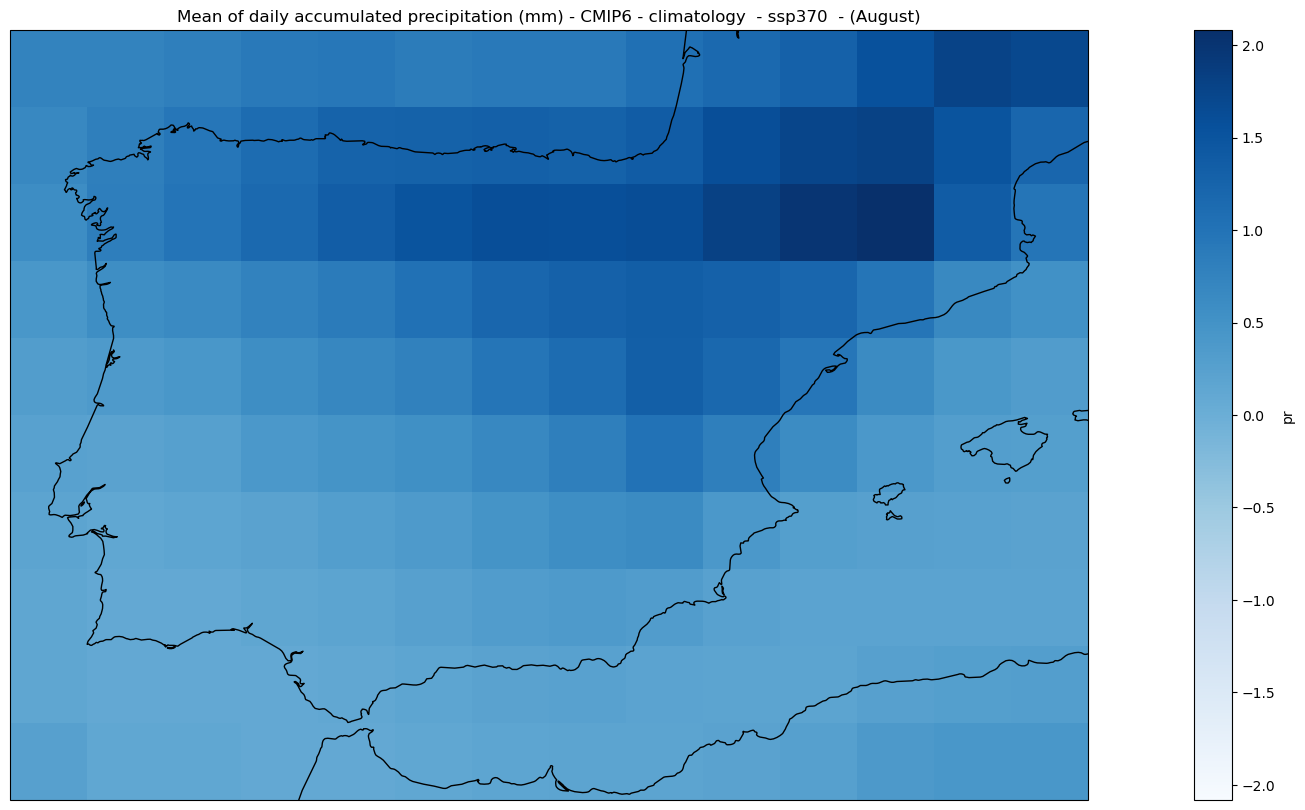

In [55]:
fig = hatched_map_plot(mean_map_ds, var, attrs, mode = 'climatology', cmap = 'Blues')

## Absolute change

### Analysis
The **categories_robustness** function calculate the category of robustness of the climate signal for each gridbox, using the same approaches as those in the IPCC WGI AR6 report (Cross-Chapter Box Atlas.1).

Robustness is defined based on three categories: No overlay indicates that the change is robust and likely emerges from internal variability (at least 80% of the models agree on the sign of change and at least 66% of the models show a change greater than the internal-variability threshold); diagonal lines (\) indicate no change or no robust change (fewer than 66% of the models show change greater than the internal-variability threshold); crossed lines (X) indicate conflicting signals where at least 66% of the models show change greater than the internal-variability threshold but fewer than 80% of all models agree on the sign of change.

Note that robustness results are computed at a gridbox level and are not representative of regionally aggregated results over larger regions (less influenced by local variability).

In [56]:
mode = 'change'
diff = 'abs'
period = slice('2081', '2100')
baseline_period = slice('1981', '2010')

In [57]:
mean_map_ds = mean_values_map(ds, var, project, mode = mode, diff = diff, 
                              season = season, period = period,
                              baseline_period = baseline_period)

In [58]:
# calculate robusteness 
# Note that this product is time-cosuming and can take several minutes
categories_ds = categories_robustness(ds, var, season = season, 
                                      period = period,
                                      baseline_period = baseline_period)

### Plot

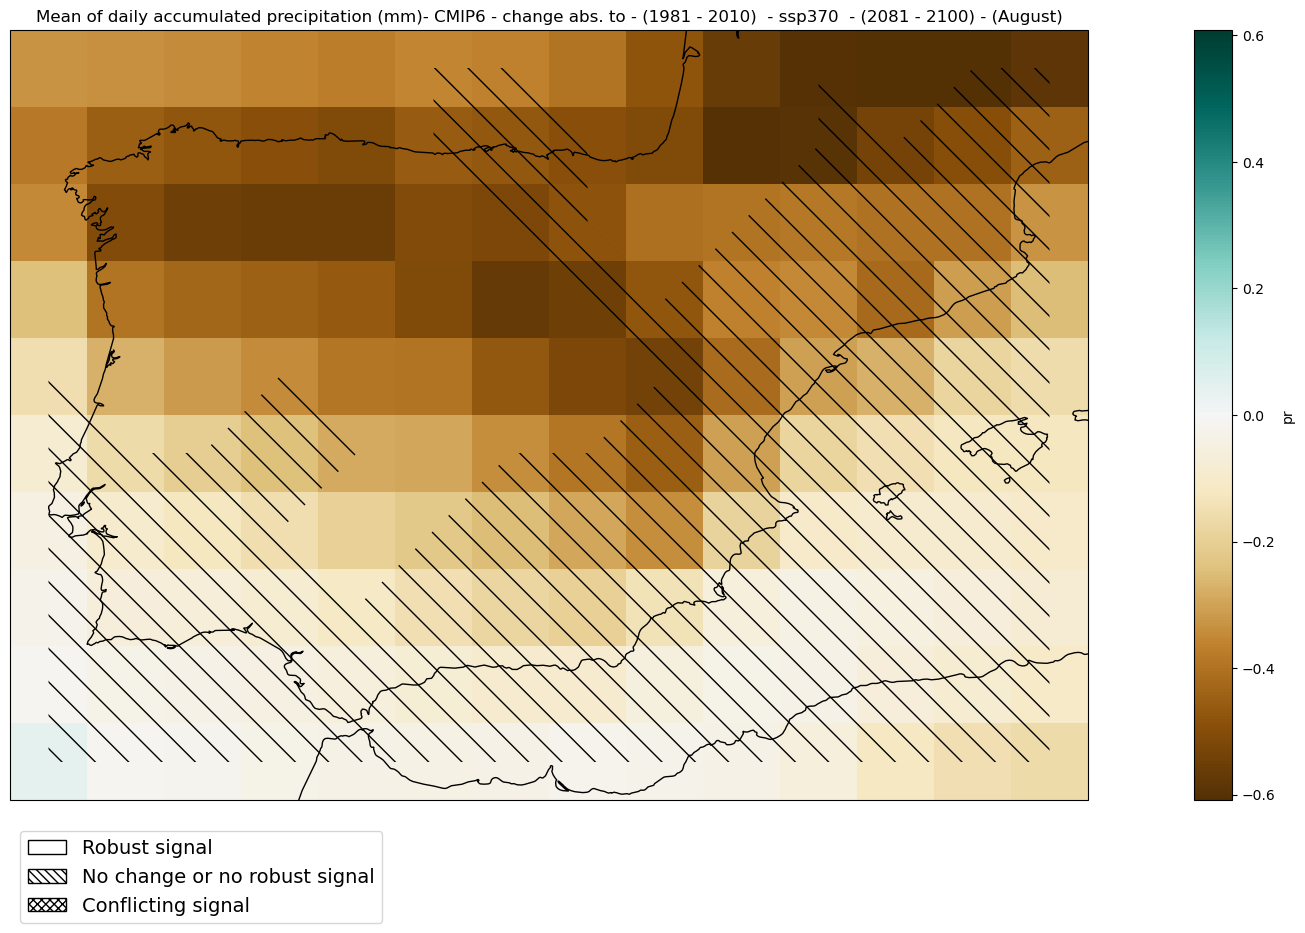

In [59]:
fig = hatched_map_plot(mean_map_ds, var, attrs, 
                       mode = mode, diff = diff, 
                       categories = categories_ds[0], 
                       period = period, baseline_period = baseline_period,
                       cmap = 'BrBG')

## Relative Change

In [60]:
mode = 'change'
diff = 'rel'
period=slice('2081', '2100')
baseline_period=slice('1981', '2010')

In [61]:
mean_map_ds = mean_values_map(ds, var, project, mode = mode, diff = diff, 
                              season = season, period = period,
                              baseline_period = baseline_period)

In [62]:
# The robustness analysis is indifferent to the mode (abs/rel)
#categories_ds = categories_robustness(ds, var, months = season, 
#                                      period = period,
#                                      baseline_period = baseline_period)

### Plot

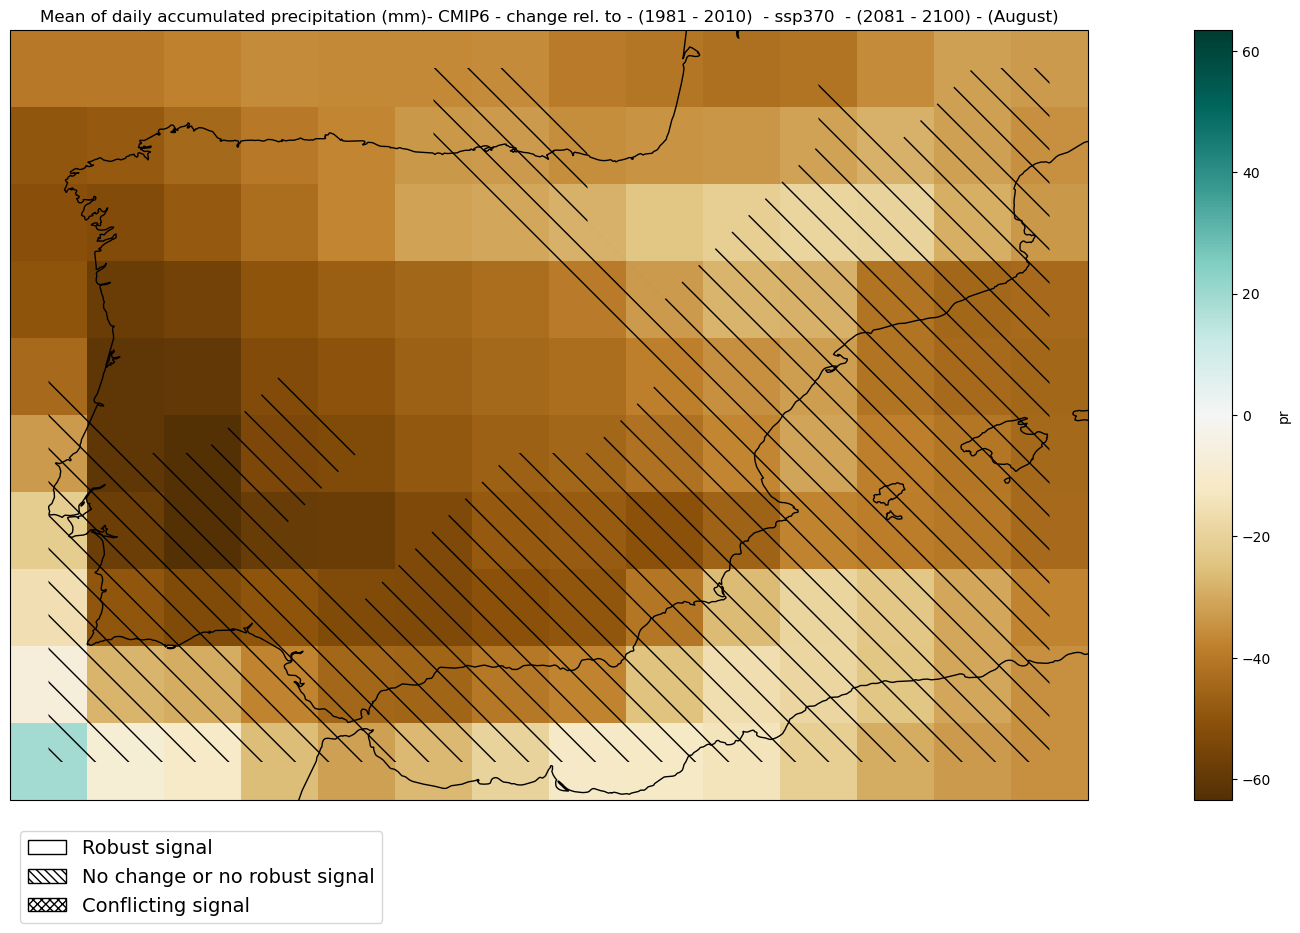

In [63]:
fig = hatched_map_plot(mean_map_ds, var, attrs, 
                       mode = mode, diff = diff, 
                       categories = categories_ds[0], 
                       period = period, baseline_period = baseline_period,
                       cmap = 'BrBG')

## Global warning levels
Here, the spatial map is displayed for a specific Global Warming Level (GWL). To achieve this, the 20-year period in which each ensemble member reaches the chosen GWL is selected. The spatial map is then shown, representing either climatology or change for this specific period and region (Spain in this notebook).

These periods are calculated in the notebook [GWLs.ipynb](GWLs.ipynb) for CMIP5 and CMIP6. For CORDEX, the results from the driving CMIP5 models are used.

In [64]:
GWL = '4'

In [65]:
#Load the data and get the intersection of the members
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(ds, GWLs_ds, project, scenario, GWL)
[GWL_data, filtered_GWLs_ds]=get_mean_data_by_months(ds, GWLs_members_with_period)

### Analysis

In [66]:
mode = 'change'
diff = 'abs'
baseline_period = slice('1981', '2010')

In [67]:
mean_map_ds = mean_values_map(filtered_GWLs_ds, var, project, mode = mode,  
                            diff = diff, season = season, 
                            baseline_period = baseline_period, GWLs_ds = GWL_data)

In [68]:
categories_ds = categories_robustness(filtered_GWLs_ds, var, season = season, 
                                       baseline_period =  baseline_period, 
                                       GWLs_ds = GWL_data)

### Plot

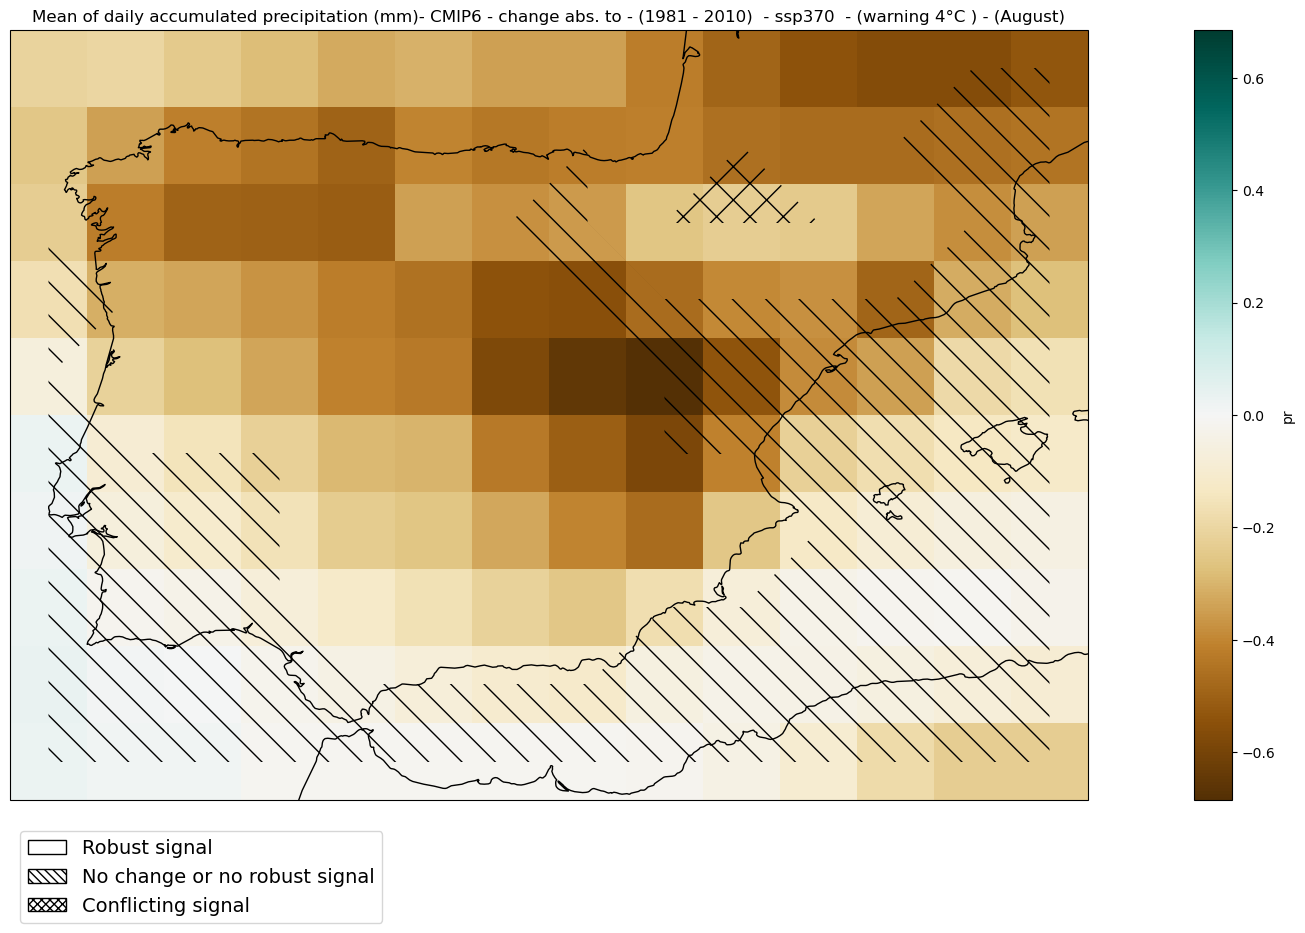

In [69]:
hatched_map_plot(mean_map_ds, var, attrs, mode = mode, diff = diff, 
                 categories = categories_ds[0], 
                 baseline_period = baseline_period, GWLs = GWL,
                 cmap = 'BrBG')

## Trends
Trend analysis is only available for observations and reanalysis. This type of analysis is not appropriate for projections since climate change does not necessarily scale linearly with global warming.

#### Download data from the "Copernicus Interactive Climate Atlas: gridded monthly dataset"

In [70]:
project = "ERA5"
var = 't'
season = [8]
trend_period = period = slice('1991','2020')

In [71]:
dest = Path('./data/ERA5')
os.makedirs(dest, exist_ok=True)

In [ ]:
filename = 't_ERA5_mon_194001-202212.zip'

dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'era5',
    'domain': 'global',
    'period': '1940-2022',
    'variable': 'monthly_mean_of_daily_mean_temperature',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [73]:
ds = xr.open_dataset(dest / "t_ERA5_mon_194001-202212.nc")

In [74]:
attrs = {
    "project" : project,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

### Analysis
The **significance_trens** function calculates and returns p-values for linear regression trends for each latitude-longitude point. Robustness is defined using the significance of the linear trends as obtained from standard hypothesis testing (and obscuring regions with non-significant trends using "x"). 

In [75]:
ds = significance_trends(ds, var, season, trend_period = trend_period)

### Plot

In [76]:
mode = 'trends'
pvalue = 0.05 # level of significance

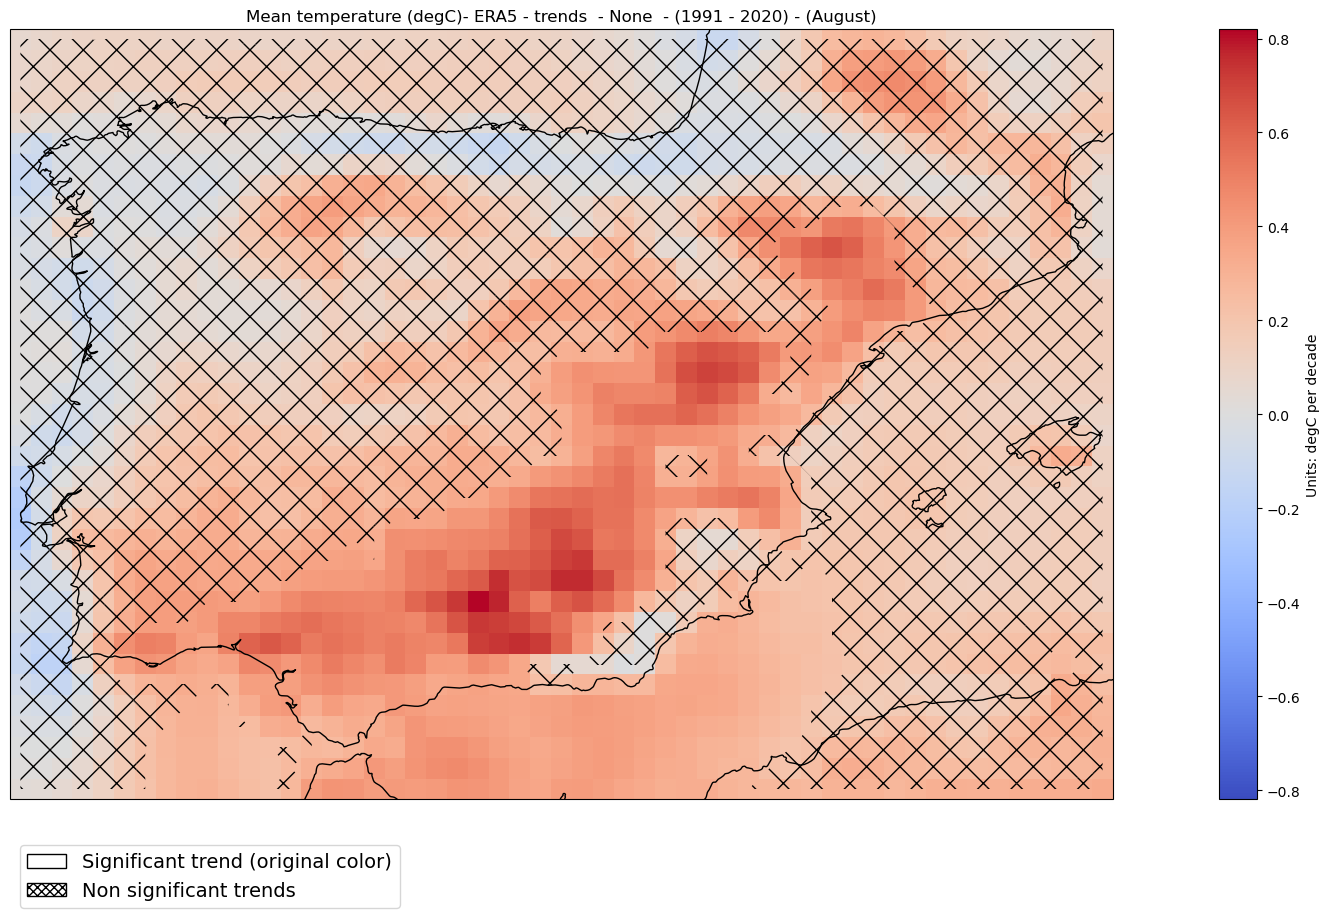

In [77]:
hatched_map_plot(ds, var, attrs, mode = mode, 
                 period = period, pvalue = 0.05, cmap = 'coolwarm')